# WASTE MANAGEMENT

PROBLEM

Waste management is a big problem in our country. Most of the wastes end up in landfills. This leads to many issues like

* Increase in landfills
* Eutrophication
* Consumption of toxic waste by animals
* Increase in toxins
* Land, water and air pollution

APPROACH

* Analysed the components of household waste
* Segregated into two classes (Organic and recyclable)
* Reduce toxic waste ending in landfills

### IMPORT LIBRARIES

In [10]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
#import skimage.io
import tensorflow 
import tqdm
import glob

from tqdm import tqdm 

#from skimage.io import imread, imshow
#from skimage.transform import resize

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten, BatchNormalization, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array

%matplotlib inline

### IMPORT DATASET 

> `TRAINING IMAGES`

In [2]:
train_o = glob.glob('C:/Users/nagap/Downloads/Dataset/TRAIN/O/*.jpg')
a = len(train_o)

In [3]:
train_r = glob.glob('../input/waste-classification-data/DATASET/TRAIN/R/*.jpg')
b = len(train_r)

In [4]:
# Total training images 

print("Nos of training samples: {}".format(a+b))

Nos of training samples: 12565


> `DATA AUGMENTATION`

In [7]:
train_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   zoom_range = 0.4,
                                   rotation_range = 10,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1.0 / 255.0)

In [6]:
train_dataset  = train_datagen.flow_from_directory(directory = 'C:/Users/nagap/Downloads/Dataset/TRAIN',
                                                   target_size = (224,224),
                                                   class_mode = 'binary',
                                                   batch_size = 128, 
                                                   subset = 'training')

Found 18052 images belonging to 2 classes.


In [7]:
valid_dataset = valid_datagen.flow_from_directory(directory = 'C:/Users/nagap/Downloads/Dataset/TRAIN',
                                                  target_size = (224,224),
                                                  class_mode = 'binary',
                                                  batch_size = 128, 
                                                  subset = 'validation')

Found 4512 images belonging to 2 classes.


In [8]:
# Class Indices 

train_dataset.class_indices

{'O': 0, 'R': 1}

100%|██████████| 5/5 [00:14<00:00,  2.98s/it]


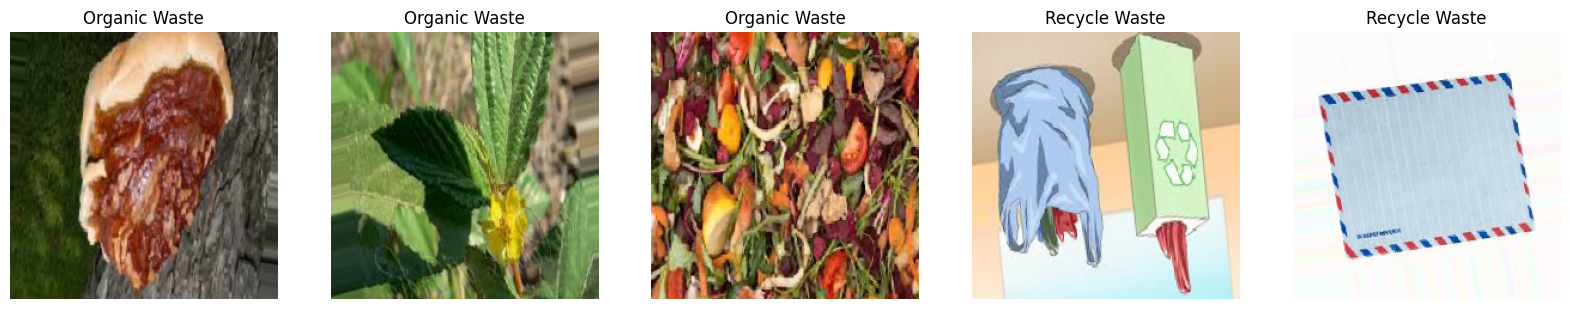

In [9]:
# Viewing Images

fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,20))

for i in tqdm(range(5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(128)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    label = train_dataset[rand1][1][rand2]
    if label == 1:
        ax[i].set_title('Recycle Waste')
    else:
        ax[i].set_title('Organic Waste')

### MODEL BUILDING

In [10]:
# Defining Model

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

base_model = ResNet50(input_shape=(224,224,3), 
                   include_top=False,
                   weights="imagenet")

In [11]:
# Freezing Layers 

for layer in base_model.layers:
    layer.trainable=False

In [12]:
# Summary

base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [13]:
# Defining Layers

model=Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))

In [14]:
# Summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 dropout (Dropout)           (None, 7, 7, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 batch_normalization (BatchN  (None, 100352)           401408    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1024)              102761472 
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             4096      
 hNormalization)                                        

In [15]:
# Model Compile 

OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)

model.compile(loss='binary_crossentropy',
              metrics=[tensorflow.keras.metrics.AUC(name = 'auc')],
              optimizer=OPT)

In [16]:
# Defining Callbacks

filepath = 'C:/Users/nagap/Downloads/best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 5,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [17]:
# Model Fitting 

model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 10,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/10
142/142 [==============================] - ETA: 0s - loss: 0.5706 - auc: 0.7963 
Epoch 1: val_auc improved from -inf to 0.84588, saving model to C:/Users/nagap/Downloads\best_weights.hdf5
142/142 [==============================] - 1814s 13s/step - loss: 0.5706 - auc: 0.7963 - val_loss: 0.5463 - val_auc: 0.8459
Epoch 2/10
142/142 [==============================] - ETA: 0s - loss: 0.5077 - auc: 0.8343 
Epoch 2: val_auc did not improve from 0.84588
142/142 [==============================] - 1887s 13s/step - loss: 0.5077 - auc: 0.8343 - val_loss: 0.5382 - val_auc: 0.8029
Epoch 3/10
142/142 [==============================] - ETA: 0s - loss: 0.4947 - auc: 0.8415 
Epoch 3: val_auc improved from 0.84588 to 0.86088, saving model to C:/Users/nagap/Downloads\best_weights.hdf5
142/142 [==============================] - 1952s 14s/step - loss: 0.4947 - auc: 0.8415 - val_loss: 0.4713 - val_auc: 0.8609
Epoch 4/10
142/142 [==============================] - ETA: 0s - loss: 0.4785 - auc: 0.851

### MODEL EVALUATION

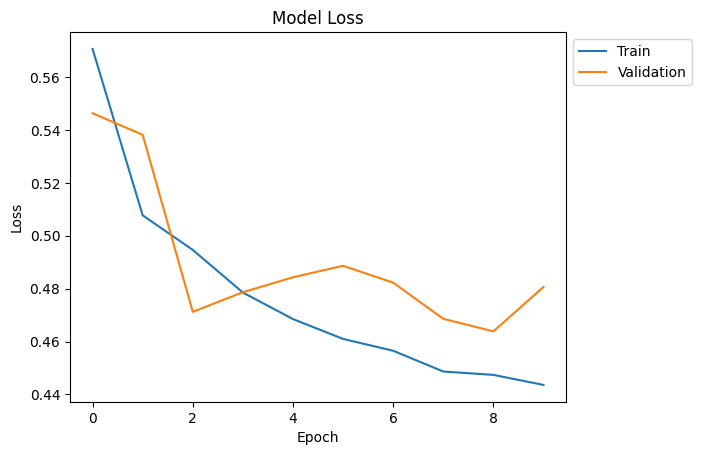

In [18]:
# Summarize the model loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

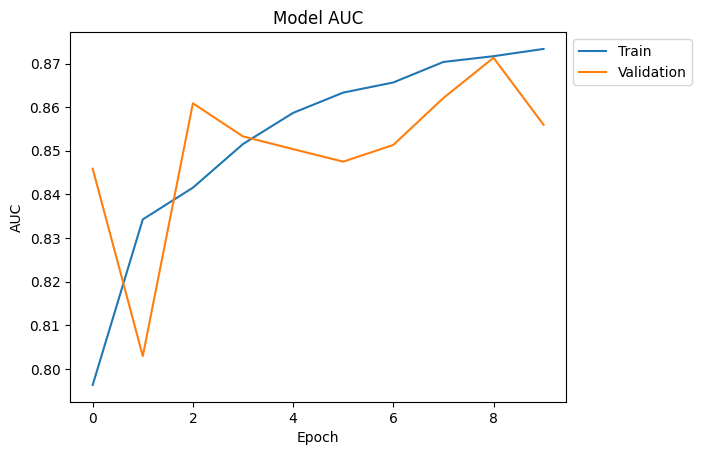

In [19]:
# Summarize models auc

plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [8]:
# Test Data 

test_data = test_datagen.flow_from_directory(directory = 'C:/Users/nagap/Downloads/Dataset/TEST',
                                             target_size = (224,224),
                                             class_mode = 'binary',
                                             batch_size = 128)

Found 2513 images belonging to 2 classes.


In [21]:
# Evaluating Loss and AUC - Test Data 

model.evaluate(test_data)

20/20 [==============================] - 140s 7s/step - loss: 0.4623 - auc: 0.8649


[0.46230772137641907, 0.8649442791938782]

In [1]:
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from glob import glob
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2


1/1 [==============================] - 0s 140ms/step
The image belongs to Organic waste category 


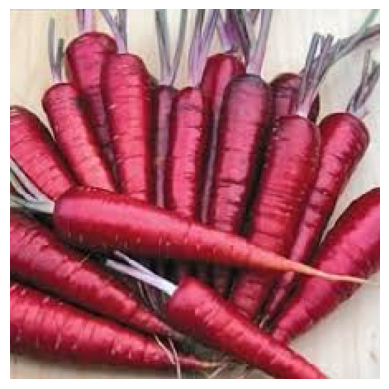

In [13]:
# Test Case:1 - ORGANIC

dic = test_data.class_indices
idc = {k:v for v,k in dic.items()}

img = load_img('C:/Users/nagap/Downloads/Dataset/TEST/O/O_12650.jpg', target_size=(224,224))
img = img_to_array(img)
img = img / 255
plt.imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model_history.predict(img)

if answer[0][0] > 0.5:
    print("The image belongs to Recycle waste category")
else:
    print("The image belongs to Organic waste category ")

1/1 [==============================] - 0s 129ms/step
The image belongs to Recycle waste category


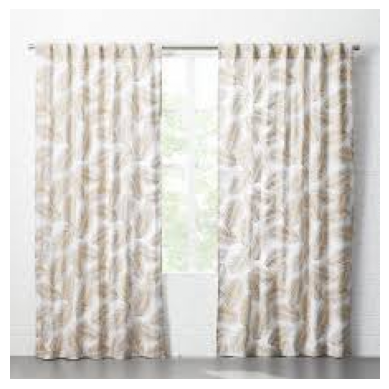

In [15]:
# Test Case:2 - RECYCLE

dic = test_data.class_indices
idc = {k:v for v,k in dic.items()}

img = load_img('C:/Users/nagap/Downloads/Dataset/TEST/R/R_10011.jpg', target_size=(224,224))
img = img_to_array(img)
img = img / 255
plt.imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model_history.predict(img)

if answer[0][0] > 0.5:
    print("The image belongs to Recycle waste category")
else:
    print("The image belongs to Organic waste category ")